# StyleGAN

**Credits**: 

The code is based on [github_1](https://github.com/davidsosa/GANs) and [github_2](https://github.com/rosinality/style-based-gan-pytorch)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    FULL_DEVICE = 'cuda:{}'.format(GPU_DEVICE)
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

In [2]:
import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm import tqdm

from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data
# from dgm_utils import load_pickle 

In [3]:
import torch.distributions as TD
import pickle

In [4]:
def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu().clamp_(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow, padding=0)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()

## 1. Mapping Network

In [5]:
class MappingLayers(nn.Module):
    
    '''
    Mapping Layers Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        hidden_dim: the inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''
 
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            # A neural network which takes in tensors of 
            # shape (n_samples, z_dim) and outputs (n_samples, w_dim)
            # with a hidden layer with hidden_dim neurons
            nn.Linear(z_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, w_dim)
        )

    def forward(self, noise):
        '''
        Function for completing a forward pass of MappingLayers: 
        Given an initial noise tensor, returns the intermediate noise tensor.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.mapping(noise)

## 2. Truncation trick

In [6]:
from scipy.stats import truncnorm
def get_truncated_noise(n_samples, z_dim, truncation):
    '''
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    '''
    truncated_noise = truncnorm.rvs(-1*truncation, truncation, size=(n_samples, z_dim))
    return torch.Tensor(truncated_noise)

def scale_w(w, w_mean=None, w_weight=None):
    if w_mean is not None:
        w = w_mean + w_weight * (w - w_mean)
    return w

## 3. Injection Noise

In [7]:
class InjectNoise(nn.Module):
    '''
    Inject Noise Class
    Values:
        channels: the number of channels the image has, a scalar
    '''
    def __init__(self, channels):

        super().__init__()
        self.weight = nn.Parameter( # You use nn.Parameter so that these weights can be optimized
            # Initiate the weights for the channels from a random normal distribution
            torch.randn(channels)[None, :, None, None] #torch.randn((1,channels,1,1))
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of InjectNoise: Given an image, 
        returns the image with random noise added.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
        '''
        # Set the appropriate shape for the noise!

        noise_shape = (image.shape[0], 1, image.shape[2], image.shape[3])

        noise = torch.randn(noise_shape, device=image.device) # Creates the random noise
        return image + self.weight * noise # Applies to image after multiplying by the weight for each channel


## 4. Adaptive Normalization

In [8]:
# Adaptive Instance Norm
class AdaIN(nn.Module):
    '''
    AdaIN Class
    Values:
        channels: the number of channels the image has, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
    '''

    def __init__(self, channels, w_dim):
        super().__init__()

        # Normalize the input per-channels
        self.instance_norm = nn.InstanceNorm2d(channels)

        # You want to map w to a set of style weights per channel.
        # Replace the Nones with the correct dimensions - keep in mind that 
        # both linear maps transform a w vector into style weights 
        # corresponding to the number of image channels.
        self.style_scale_transform = nn.Linear(w_dim, channels)
        self.style_shift_transform = nn.Linear(w_dim, channels)

    def forward(self, image, w):
        '''
        Function for completing a forward pass of AdaIN: Given an image and intermediate noise vector w, 
        returns the normalized image that has been scaled and shifted by the style.
        Parameters:
            image: the feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector w
        '''
        normalized_image = self.instance_norm(image) # (bs, c, w, h)
        style_scale = self.style_scale_transform(w)[:, :, None, None]
        style_shift = self.style_shift_transform(w)[:, :, None, None]

        # Calculate the transformed image
        transformed_image = style_scale * normalized_image + style_shift
        return transformed_image

## 5. Progressive GAN

In [9]:
class MicroStyleGANGeneratorBlock(nn.Module):
    '''
    Micro StyleGAN Generator Block Class
    Values:
        in_chan: the number of channels in the input, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        kernel_size: the size of the convolving kernel
        starting_size: the size of the starting image
    '''

    def __init__(
        self, 
        in_chan, 
        out_chan, 
        w_dim, 
        kernel_size, 
        starting_size, 
        use_upsample=True):

        super().__init__()
        self.use_upsample = use_upsample

        if self.use_upsample:
            self.upsample = nn.Upsample(starting_size, mode='bilinear')
        self.conv = nn.Conv2d(in_chan, out_chan, kernel_size, padding=kernel_size // 2) # Padding is used to maintain the image size
        self.inject_noise = InjectNoise(out_chan)
        self.adain = AdaIN(out_chan, w_dim)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        '''
        Function for completing a forward pass of MicroStyleGANGeneratorBlock: Given an x and w, 
        computes a StyleGAN generator block.
        Parameters:
            x: the input into the generator, feature map of shape (n_samples, channels, width, height)
            w: the intermediate noise vector
        '''
        if self.use_upsample:
            x = self.upsample(x)
        x = self.conv(x)
        x = self.inject_noise(x)
        x = self.activation(x)
        x = self.adain(x, w)
        return x

class StyledSequential(nn.Sequential):

    def forward(self, x, w):
        for module in self._modules.values():
            x = module(x, w)
        return x

In [10]:
class MicroStyleGANGenerator(nn.Module):
    '''
    Micro StyleGAN Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        map_hidden_dim: the mapping inner dimension, a scalar
        w_dim: the dimension of the intermediate noise vector, a scalar
        in_chan: the dimension of the constant input, usually w_dim, a scalar
        out_chan: the number of channels wanted in the output, a scalar
        kernel_size: the size of the convolving kernel
        hidden_chan: the inner dimension, a scalar
    '''

    def _sample_prior(self, n):
        x = self.prior.sample((n, self.z_dim))
        return x

    def __init__(self, 
                 z_dim, # z dimensionality
                 map_hidden_dim, # mapping network parameter
                 w_dim, # style vector dimensionality
                 in_chan, # number of channels in input trainable tensor
                 out_chan, # images dimensionality
                 kernel_size, 
                 hidden_chan, device='cuda'):
        super().__init__()
        self.prior = TD.Normal(torch.tensor(0.0).to(device), torch.tensor(1.0).to(device))
        self.z_dim = z_dim
        self.map = MappingLayers(z_dim, map_hidden_dim, w_dim)
        # Typically this constant is initiated to all ones, but you will initiate to a
        # Gaussian to better visualize the network's effect
        self.starting_constant = nn.Parameter(torch.randn(1, in_chan, 4, 4))

        self.progression = nn.ModuleList(
            [
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(in_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 4, use_upsample=False)]),
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8, use_upsample=True),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 8, use_upsample=False)]),
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16, use_upsample=True),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 16, use_upsample=False)]),
                StyledSequential(*[
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 32, use_upsample=True),
                    MicroStyleGANGeneratorBlock(hidden_chan, hidden_chan, w_dim, kernel_size, 32, use_upsample=False)])
            ]
        )

        self.to_rgb = nn.ModuleList(
            [
                nn.Sequential(*[nn.Conv2d(hidden_chan, out_chan, kernel_size=1), nn.Tanh()]), # out_chan = 3
                nn.Sequential(*[nn.Conv2d(hidden_chan, out_chan, kernel_size=1), nn.Tanh()]),
                nn.Sequential(*[nn.Conv2d(hidden_chan, out_chan, kernel_size=1), nn.Tanh()]),
                nn.Sequential(*[nn.Conv2d(hidden_chan, out_chan, kernel_size=1), nn.Tanh()])
            ]
        )

    def forward(self, noise, step=0, alpha=-1, w_mean=None, w_weight=None):
        '''
        Function for completing a forward pass of MicroStyleGANGenerator: Given noise, 
        computes a StyleGAN iteration.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
            return_intermediate: a boolean, true to return the images as well (for testing) and false otherwise
        '''
        x = self.starting_constant
        w = self.map(noise)
        w = scale_w(w, w_mean, w_weight)

        for i, (conv, to_rgb) in enumerate(zip(self.progression, self.to_rgb)):

            if i > 0 and step > 0:
                x_prev = x

            x = conv(x, w)

            if i == step:
                x = to_rgb(x)

                if i > 0 and 0 <= alpha < 1:
                    skip_rgb = self.to_rgb[i - 1](x_prev)
                    skip_rgb = F.interpolate(skip_rgb, scale_factor=2, mode='bilinear')
                    x = (1 - alpha) * skip_rgb + alpha * x

                break

        return x

    def sample(self, n, step=0, alpha=-1, w_mean=None, w_weight=None):
        with torch.no_grad():
            return self.rsample(n, step, alpha, w_mean, w_weight)

    def rsample(self, n, step=0, alpha=-1, w_mean=None, w_weight=None):
        noise = self._sample_prior(n)
        return self.forward(noise, step, alpha, w_mean, w_weight)

### 5.1 Unit tests

In [11]:
z_dim = 128
out_chan = 3
truncation = 0.7

SG_generator = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=256,
    w_dim=64,
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32,
    device='cpu'
)

test_samples = 10
test_result = SG_generator(get_truncated_noise(test_samples, z_dim, truncation), step=3)

# Check if the block works
assert tuple(test_result.shape) == (test_samples, out_chan, 32, 32)

In [12]:
SG_generator.sample(10, step=3).shape

torch.Size([10, 3, 32, 32])

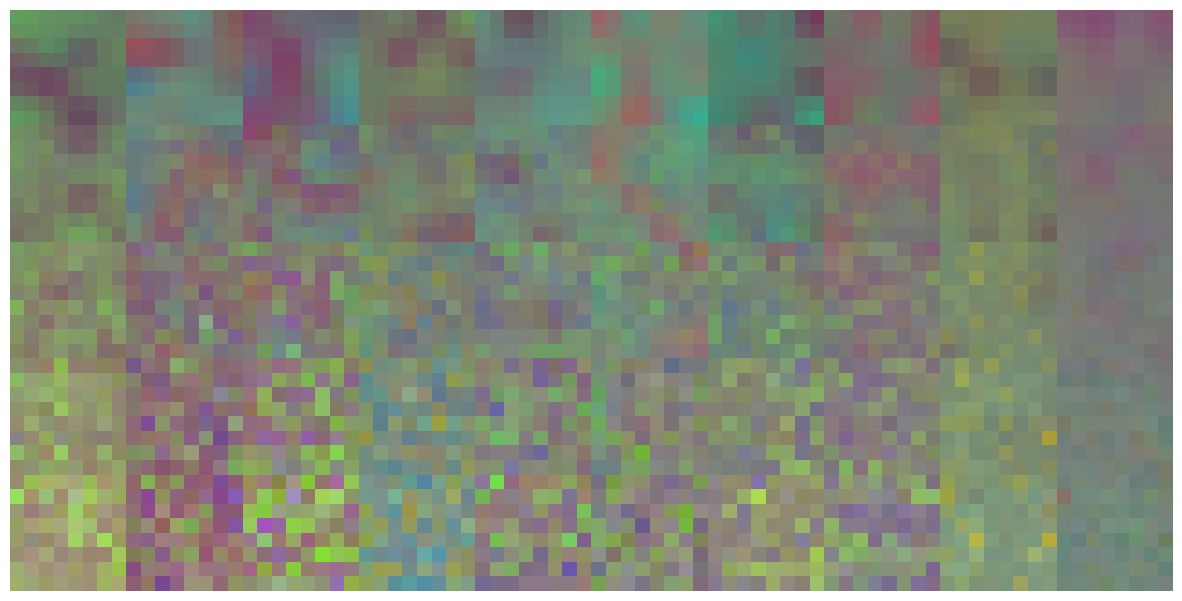

In [13]:
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

viz_samples = 10
# The noise is exaggerated for visual effect
viz_noise = get_truncated_noise(viz_samples, z_dim, truncation) * 10

SG_generator.eval()
images = []
for alpha in np.linspace(0, 1, num=5):
    viz_result =  SG_generator(viz_noise, step=1, alpha=alpha)
    images += [tensor for tensor in viz_result]
show_tensor_images(torch.stack(images), nrow=viz_samples, num_images=len(images))
SG_generator = SG_generator.train()

## 6. Discriminator

In [14]:
class ConvBlock(nn.Module):

    def __init__(
        self,
        in_channel,
        out_channel,
        kernel_size,
        downsample=False,
    ):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, padding=kernel_size//2),
            nn.LeakyReLU(0.2),
        )

        if downsample:
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size, padding=kernel_size//2),
                nn.AvgPool2d(2),
                nn.LeakyReLU(0.2),
            )

        else:
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channel, out_channel, kernel_size, padding=kernel_size//2),
                nn.LeakyReLU(0.2),
            )

    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)

        return out

class Discriminator(nn.Module):

    def __init__(
        self, 
        in_chan,
        out_chan, 
        kernel_size, 
        hidden_chan):

        super().__init__()

        self.progression = nn.ModuleList(
            [
                ConvBlock(hidden_chan, hidden_chan, kernel_size, downsample=True), # 16
                ConvBlock(hidden_chan, hidden_chan, kernel_size, downsample=True), # 8
                ConvBlock(hidden_chan, hidden_chan, kernel_size, downsample=True), # 4
                nn.Sequential(*[
                    nn.Conv2d(hidden_chan, hidden_chan, kernel_size, padding=kernel_size//2),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(hidden_chan, in_chan, 4, padding=0),
                    nn.LeakyReLU(0.2)])
            ]
        )

        self.from_rgb = nn.ModuleList(
            [
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1),
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1),
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1),
                nn.Conv2d(out_chan, hidden_chan, kernel_size=1)
            ]
        )

        self.n_layer = len(self.progression)

        self.linear = nn.Linear(in_chan, 1)

    def forward(self, input, step=0, alpha=-1):
        out = self.from_rgb[self.n_layer - step - 1](input)
        out = self.progression[self.n_layer - step - 1](out)

        if step > 0 and  0 <= alpha < 1:
            skip_rgb = F.avg_pool2d(input, 2)
            skip_rgb = self.from_rgb[self.n_layer - step](skip_rgb)
            out = (1 - alpha) * skip_rgb + alpha * out

        for i in range(step - 1, -1, -1):
            index = self.n_layer - i - 1
            out = self.progression[index](out)

        out = out.squeeze(2).squeeze(2)
        # print(input.size(), out.size(), step)
        out = self.linear(out)

        return out

### 6.1 Unit tests

In [15]:
SG_discriminator = Discriminator(
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32
)

In [16]:
viz_result =  SG_generator(viz_noise, step=2, alpha=0.5)

In [17]:
viz_result.shape

torch.Size([10, 3, 16, 16])

In [18]:
discr_results = SG_discriminator(viz_result, step=2, alpha=0.5)

In [19]:
discr_results.shape

torch.Size([10, 1])

## 7. Dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


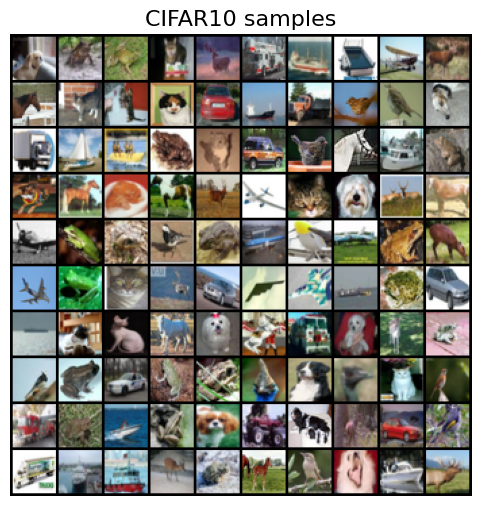

In [20]:
from dgm_utils import load_dataset
train_data, test_data = load_dataset('cifar10', binarize=False)
visualize_images(train_data, 'CIFAR10 samples')

In [21]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import skimage.measure

class MultiResCIFAR10Dataset(Dataset):

    res2avgpoolops = {
        32: 0,
        16: 1,
        8: 2,
        4: 3,
        2: 4
    }

    @property
    def resolution(self):
        return self._resolution

    @resolution.setter
    def resolution(self, val):
        assert val in [2, 4, 8, 16, 32]
        self._resolution = val
        self._avgpoolops = self.res2avgpoolops[val]
        if val in self.data.keys():
            return
        self.data[val] = np.asarray([
            self.np_avgpool2(self.transform(self.init_data[i]), self._avgpoolops) for i in range(len(self.init_data))])

    def np_avgpool2(self, x, num_apply):
        for _ in range(num_apply):
            x = skimage.measure.block_reduce(x, (1, 2, 2), np.mean)
        return x

    def __init__(
        self, 
        data,
        resolution=32,
        transform=lambda x: x,
    ):
        super().__init__()
        self.init_data = data
        self.data = {}
        self.transform = transform
        self.resolution = resolution
        self.transform = transform

    def __len__(self):
        return len(self.init_data)

    def __getitem__(self, index):
        return self.data[self.resolution][index]

In [22]:
def im2rawim(x):
    return (x - 0.5)/0.5

def rawim2im(x):
    return x/2. + 0.5

In [23]:
train_dataset = MultiResCIFAR10Dataset(train_data, transform = im2rawim, resolution=32)

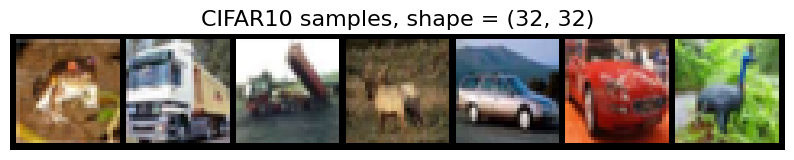

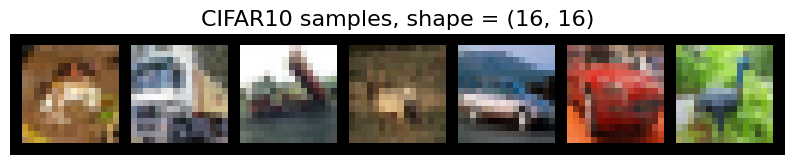

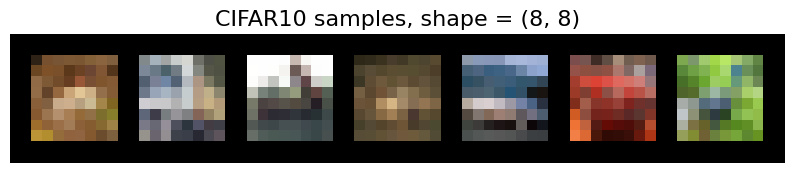

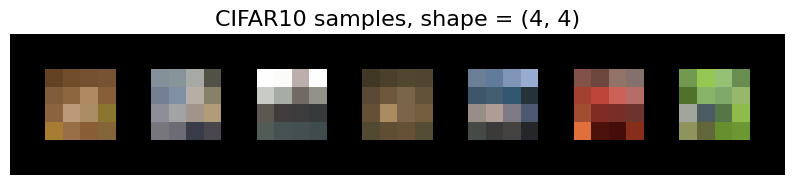

In [24]:
resolutions = [32, 16, 8, 4]
for res in resolutions:
    train_dataset.resolution = res
    dl = DataLoader(train_dataset, batch_size=7, shuffle=False)
    batch = next(iter(dl)).numpy() * 0.5 + 0.5
    show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(res), figsize=(10, 5), nrow=7)

## 8. Basic Training infrastructure

Implementation of standard `GAN` loss with $R_1$ regularizer ([paper](https://arxiv.org/pdf/1801.04406.pdf))

In [25]:
from collections import defaultdict

def get_defaultdictlist():
    return defaultdict(list)

class ImagesManager:

    def __init__(self):
        self.stats = defaultdict(get_defaultdictlist)

    def add(self, epoch, images):
        assert isinstance(images, np.ndarray)
        assert len(images.shape) == 4 # bs, c, h, w
        res = images.shape[-1]
        self.stats[res][epoch].append(images)

    def get_resolutions(self):
        return list(self.stats.keys())

    def get_epochs(self, res):
        return sorted(self.stats[res].keys())

    def get_images(self, res, epoch):
        return self.stats[res][epoch]

In [27]:
from seminar9_utils import computePotGrad, StatsManager
from IPython.display import clear_output
import time

def train_GAN_R1(
    generator, # generator model
    critic, # critic model
    step, # number of progressive steps (defines the resolution under consideration)
    alpha_sheduler, # sheduler of interventions
    train_loader, # loader of the train data
    critic_steps, # number of critic steps per one generator steps
    batch_size,
    n_epochs,
    gen_lr, 
    critic_lr,
    SM, # stats manager to store losses
    IM, # images manager to store images
    start_epoch = 0,
    gp_weight=10, # coefficient of R1 gradient penalty
    use_cuda=True,
    visualize_steps=10,
    save_steps=200
):

    critic.train()
    generator.train()

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=gen_lr, betas=(0, 0.9))
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_lr, betas=(0, 0.9))

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)

    for epoch_i in tqdm(range(start_epoch, n_epochs + start_epoch)):
        for batch_i, real_data in enumerate(train_loader):
            curr_iter += 1
            alpha = alpha_sheduler(curr_iter)
            if use_cuda:
                real_data = real_data.cuda()

            ################
            # CRITIC UPDATE

            critic_optimizer.zero_grad()
            real_data.requires_grad_() # for R1 regularizer estimation
            real_scores = critic(real_data, step=step, alpha=alpha)
            real_predict = F.softplus(- real_scores).mean()

            # R1 gradient penalty
            gradients = computePotGrad(real_data, real_scores)
            grad_penalty = (
                gradients.view(gradients.size(0), -1).norm(2, dim=1) ** 2
            ).mean()

            fake_data = generator.sample(real_data.shape[0], step=step, alpha=alpha)
            fake_scores = critic(fake_data, step=step, alpha=alpha)
            fake_predict = F.softplus(fake_scores).mean()

            d_loss = fake_predict + real_predict + gp_weight * grad_penalty

            d_loss.backward()
            critic_optimizer.step()

            SM.upd('D_loss', d_loss.item())
            SM.upd('GP', grad_penalty.item())
            SM.upd('alpha', alpha)

            ###############
            # GENERATOR_UPDATE

            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.rsample(batch_size, step=step, alpha=alpha)
                fake_scores = critic(fake_data, step=step, alpha=alpha)
                g_loss = F.softplus(-fake_scores).mean()
                g_loss.backward()
                gen_optimizer.step()
                SM.upd('G_loss', g_loss.item())

        SM.upd('step', step)

        #################
        # statistics collection
        # and visualization

        if visualize_steps and epoch_i % visualize_steps == 0:
            clear_output(wait=True)
            print('Epoch {}'.format(epoch_i))
            fig, axes = plt.subplots(3, 2, figsize=(16, 18))
            SM.draw(axes)
            plt.tight_layout()
            plt.show(); plt.close(fig)

            batch = rawim2im(SG_generator.sample(10, step=step, alpha=alpha).detach().cpu().numpy())
            show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(res), figsize=(10, 10), nrow=5)
            IM.add(epoch_i, batch)

        if save_steps and epoch_i % save_steps == save_steps - 1:
            torch.save(
                {
                    'generator': SG_generator.state_dict(),
                    'discriminator': SG_discriminator.state_dict(),
                },
                'checkpoints_gan_r1/gan_r1_loss_step_{}_epoch_{}_critic_lr_{:.5f}_gen_lr_{:.5f}_critic_steps_{}_gp_{}.pth'.format(
                    step, epoch_i, critic_lr, gen_lr, critic_steps, gp_weight)
            )

### 8.1 Alpha sheduler

Controls the intervention of the low resolution when training with higher resolution

In [28]:
class AlphaShedulerGeneric:

    def __init__(self):
        pass

    def __call__(self, it):
        raise NotImplementedError()


class ConstantAlphaSheduler(AlphaShedulerGeneric):

    def __init__(self, alpha=1.):
        super().__init__()
        self.alpha = alpha

    def __call__(self, it):
        return self.alpha

class LinearProgressiveAlphaSheduler(AlphaShedulerGeneric):

    def __init__(self, n_growing):
        super().__init__()
        assert n_growing >= 1
        self.n_growing = n_growing

    def __call__(self, it):
        return min(float(it)/self.n_growing, 1.)

## 9. Training

### 9.1  Set up generator and discriminator

In [29]:
z_dim = 128
out_chan = 3

SG_generator = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=256,
    w_dim=64,
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32
).cuda()

SG_discriminator = Discriminator(
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32
).cuda()

### 9.2 Set up parameters

In [30]:
BATCH_SIZE = 1024
CRITIC_STEPS = 1
CRITIC_LR=1e-3
GEN_LR=1e-3
GP_WEIGHT = 1.

VARY_PROGRESSIVE_PARAMS = {
    0: {
        'N_EPOCHS': 200,
        'ALPHA_SCHEDULER': ConstantAlphaSheduler(1.),
        'SAVE_STEPS': 200},
    1: {
        'N_EPOCHS': 200,
        'ALPHA_SCHEDULER': LinearProgressiveAlphaSheduler(6000),
        'SAVE_STEPS': 200},
    2: {
        'N_EPOCHS': 300,
        'ALPHA_SCHEDULER': LinearProgressiveAlphaSheduler(6000),
        'SAVE_STEPS': 300},
    3: {
        'N_EPOCHS': 600,
        'ALPHA_SCHEDULER': LinearProgressiveAlphaSheduler(6000),
        'SAVE_STEPS': 200}
}

SM = StatsManager('D_loss', 'G_loss', 'GP', 'alpha', 'step')
IM = ImagesManager()

step2res = {
    0: 4,
    1: 8,
    2: 16,
    3: 32
}

In [30]:
# # Image Manager from the complete training
# with open('checkpoints_gan_r1/im_manager.pkl', 'rb') as filehandler:
#     IM = pickle.load(filehandler)

In [31]:
# # StatsManager from the complete training
# with open('checkpoints_gan_r1/stats_manager.pkl', 'rb') as filehandler:
#     SM = pickle.load(filehandler)

### 9.3 Training the model

In [33]:
# complete training

for STEP in [0, 1, 2, 3]:
    
    # create dataloder
    train_dataset.resolution = step2res[STEP]
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # launch training
    train_GAN_R1(
        SG_generator, 
        SG_discriminator,
        STEP,
        VARY_PROGRESSIVE_PARAMS[STEP]['ALPHA_SCHEDULER'],
        train_loader,
        critic_steps=CRITIC_STEPS, 
        batch_size=BATCH_SIZE, 
        n_epochs=VARY_PROGRESSIVE_PARAMS[STEP]['N_EPOCHS'],
        gen_lr=GEN_LR,
        critic_lr=CRITIC_LR,
        SM=SM,
        IM=IM,
        gp_weight=GP_WEIGHT,
        use_cuda=True,
        visualize_steps = 20,
        save_steps=VARY_PROGRESSIVE_PARAMS[STEP]['SAVE_STEPS']
    )

## 10. Visualization and discussions

Посмотрим на семплы из модели

In [32]:
checkpoint = torch.load('checkpoints_gan_r1/gan_r1_loss_step_3_critic_lr_0.00100_gen_lr_0.00100_critic_steps_1_gp_1.0_FINAL.pth', map_location=FULL_DEVICE)
SG_generator.load_state_dict(checkpoint['generator'])

<All keys matched successfully>

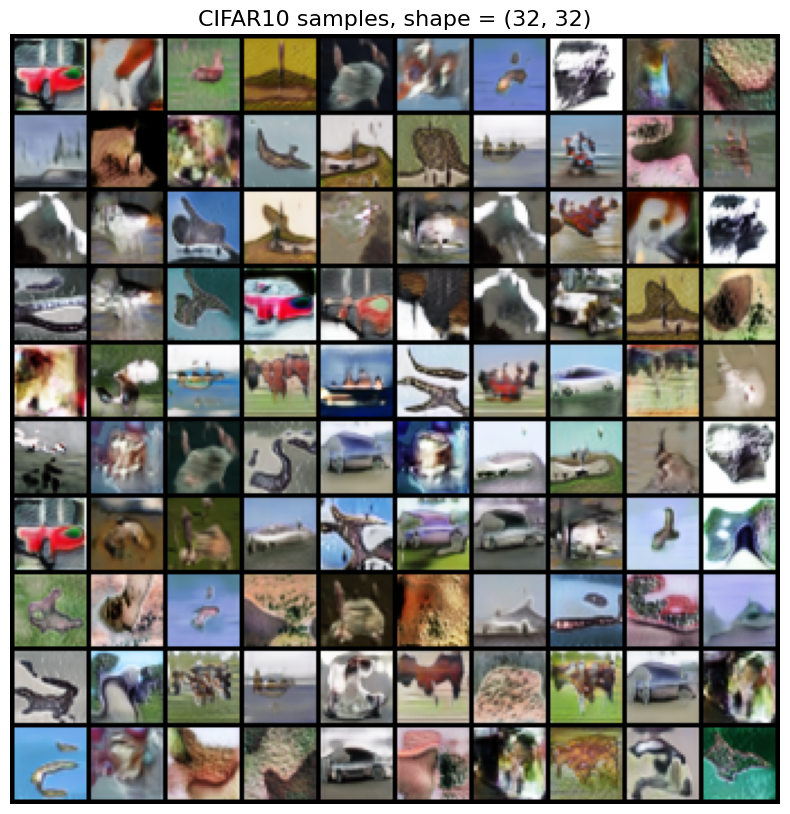

In [33]:
batch = rawim2im(SG_generator.sample(100, step=3).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(10, 10), nrow=10)

Посмотрим на лоссы в ходе обучения

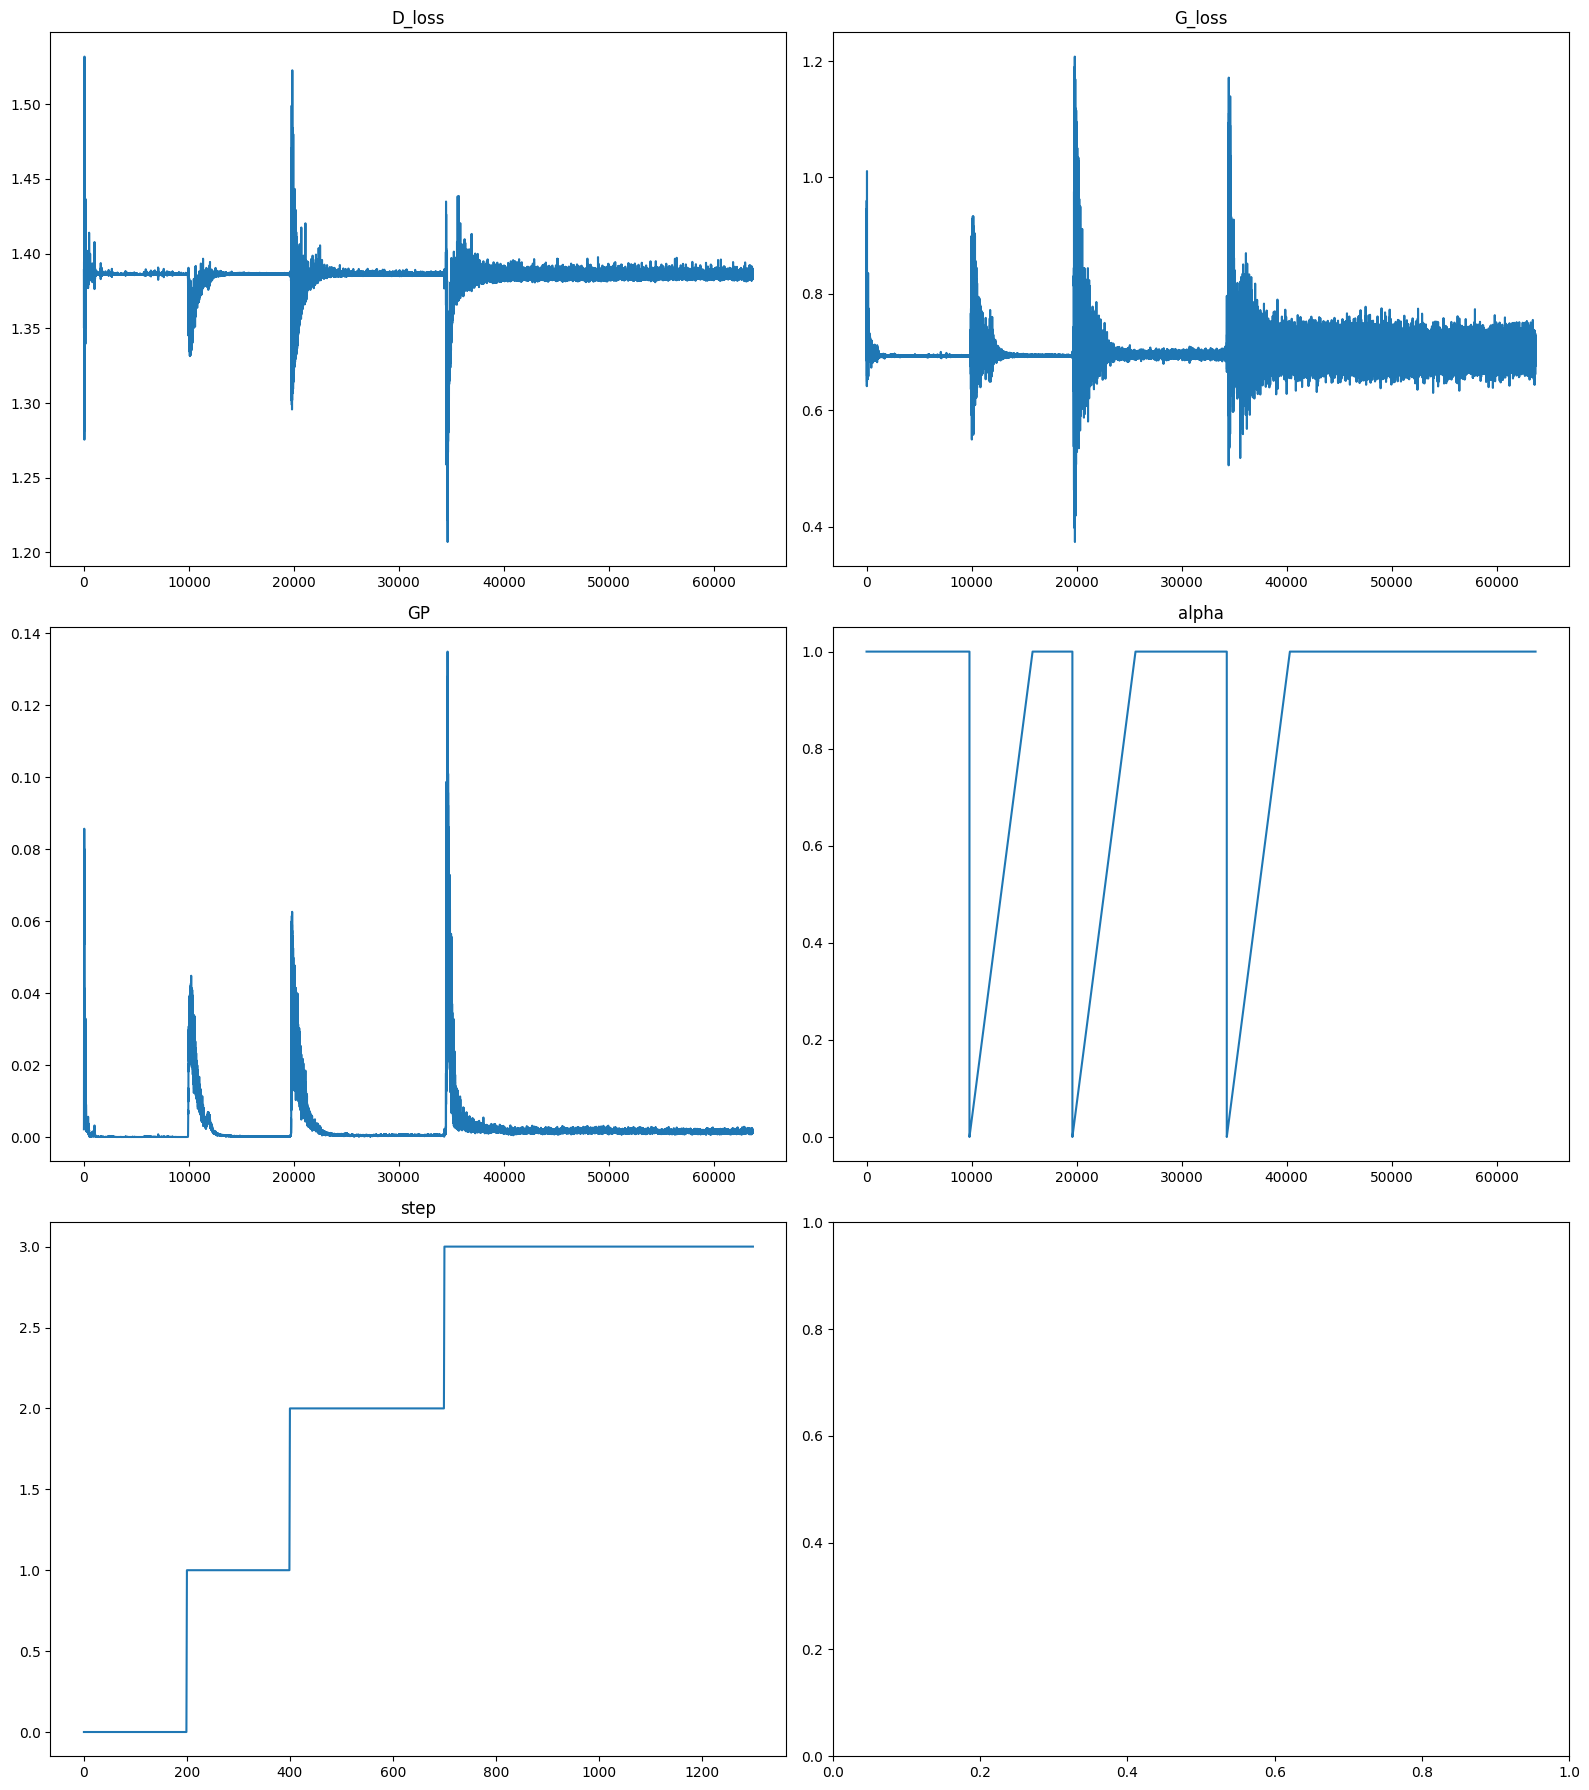

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
SM.draw(axes)
plt.tight_layout()
plt.show(); plt.close(fig)

In [61]:
# with open('checkpoints_gan_r1/im_manager.pkl', 'wb') as filehandler:
#     pickle.dump(IM , filehandler)

In [16]:
# with open('checkpoints_gan_r1/stats_manager.pkl', 'wb') as filehandler:
#     pickle.dump(SM_ , filehandler)

Посмотрим на семплы в ходе обучения

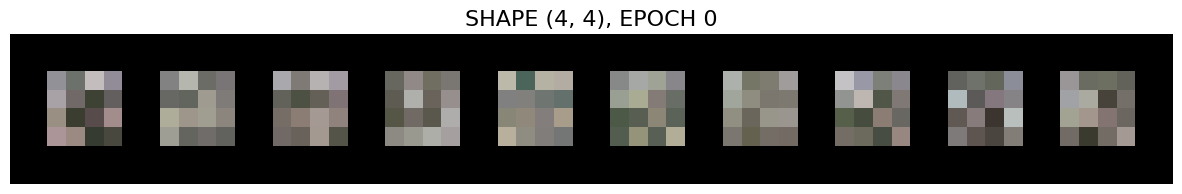

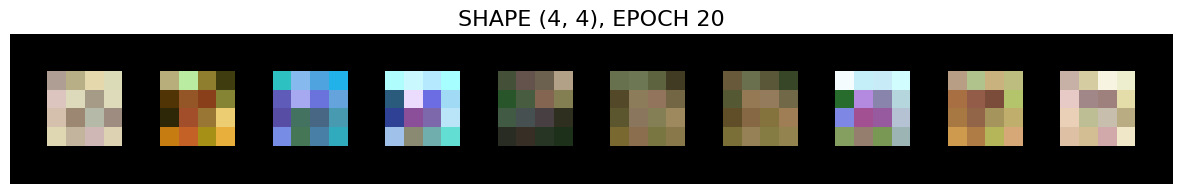

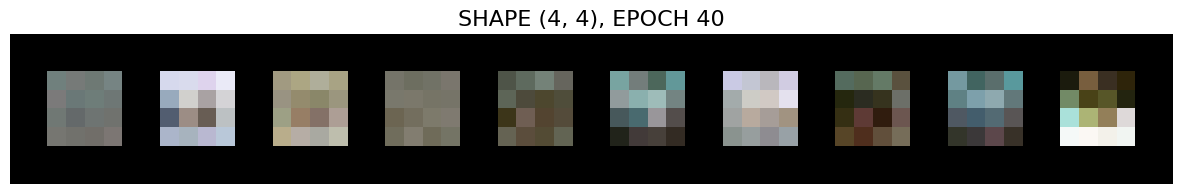

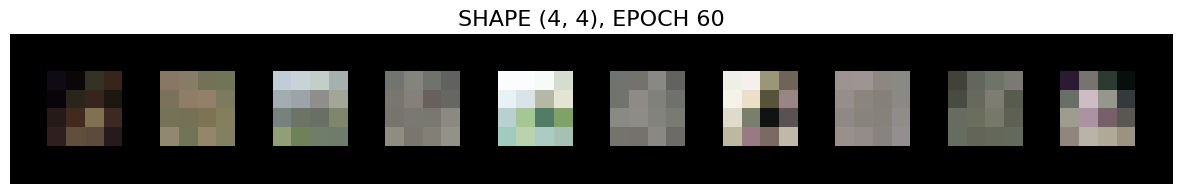

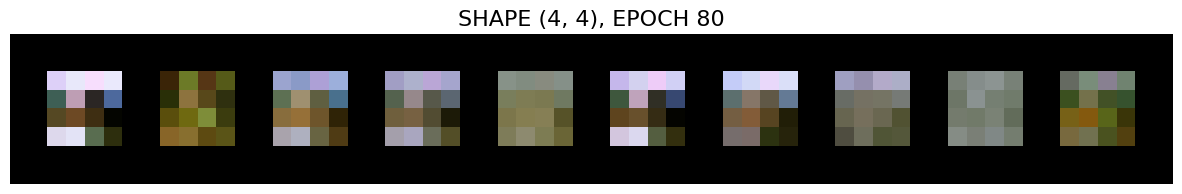

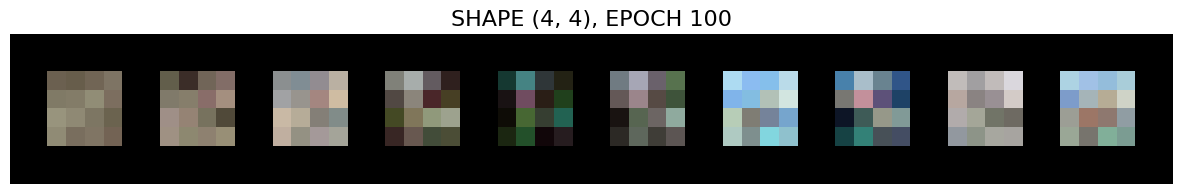

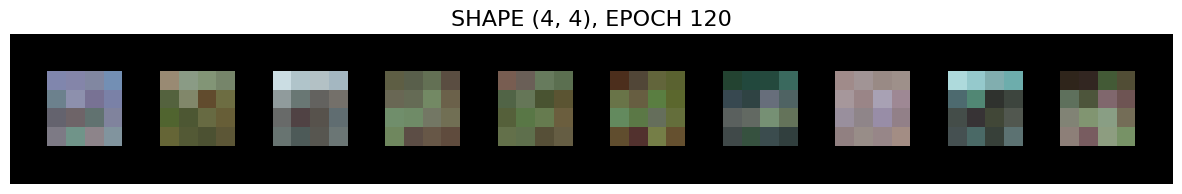

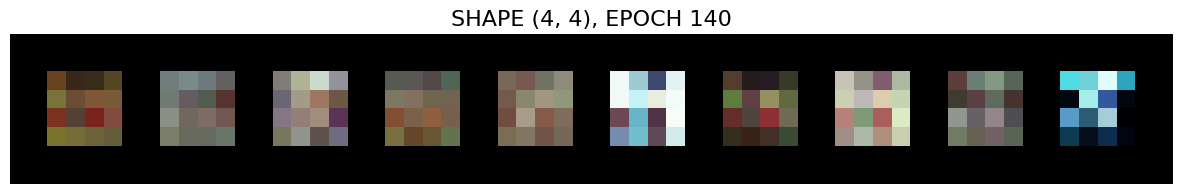

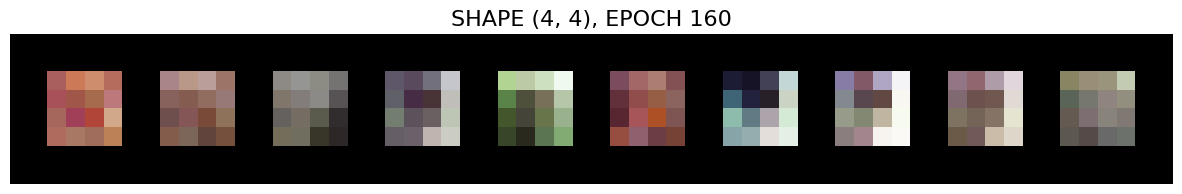

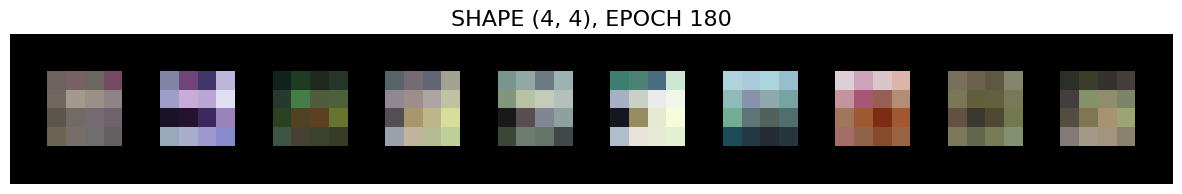

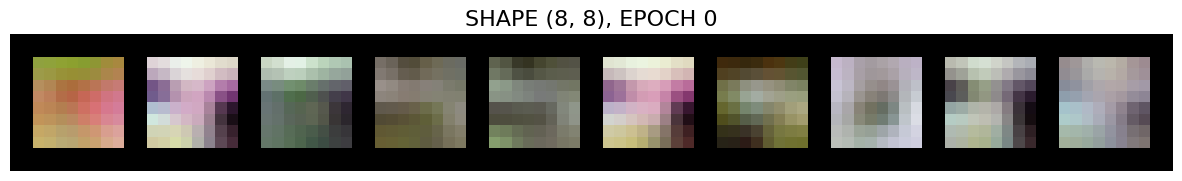

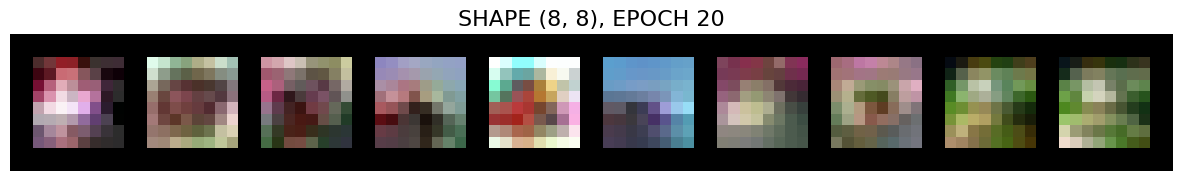

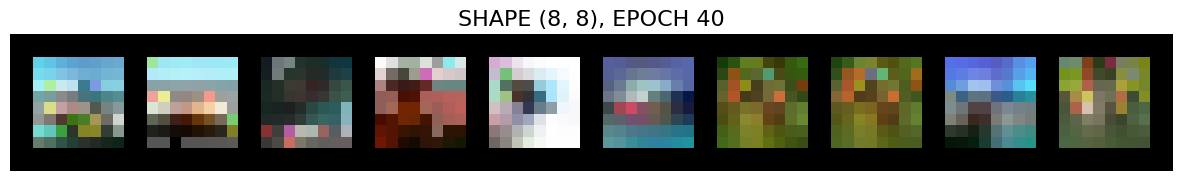

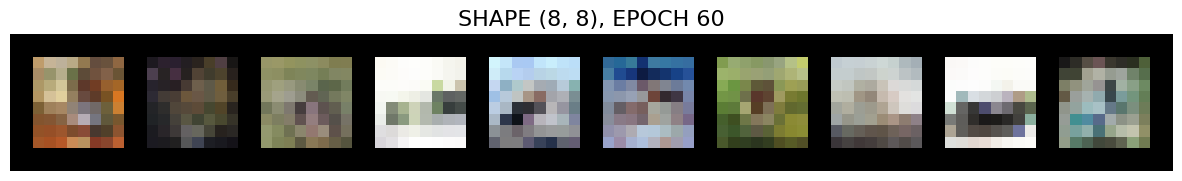

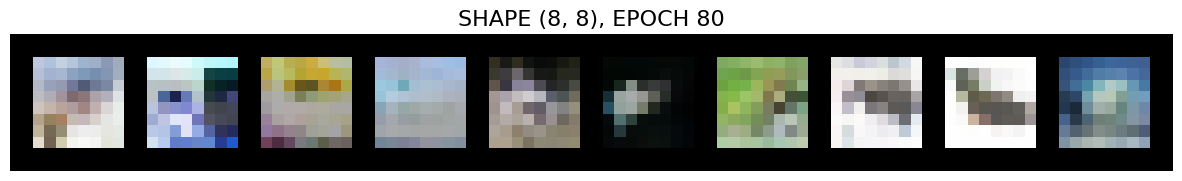

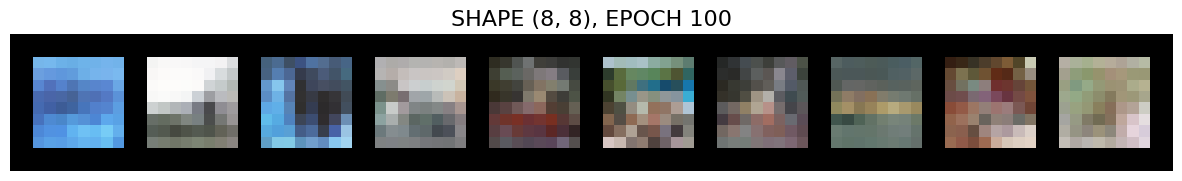

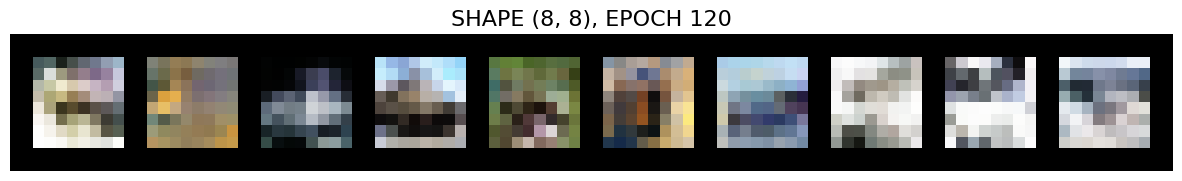

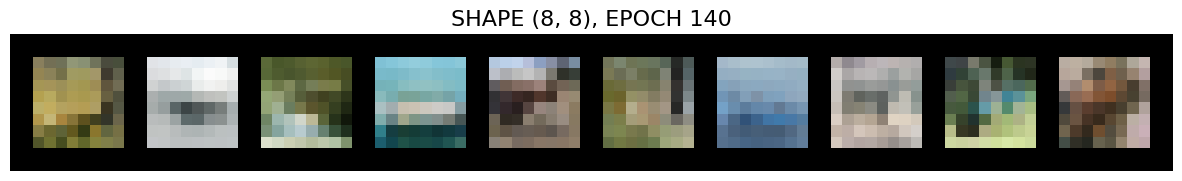

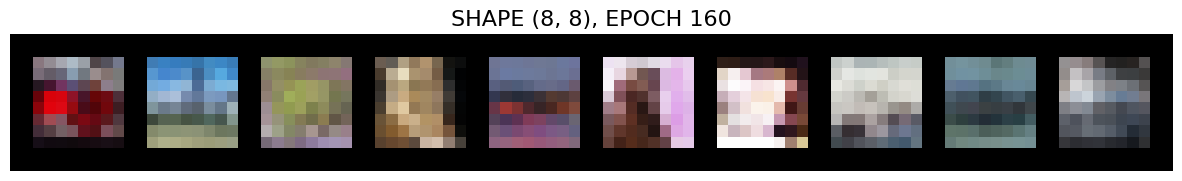

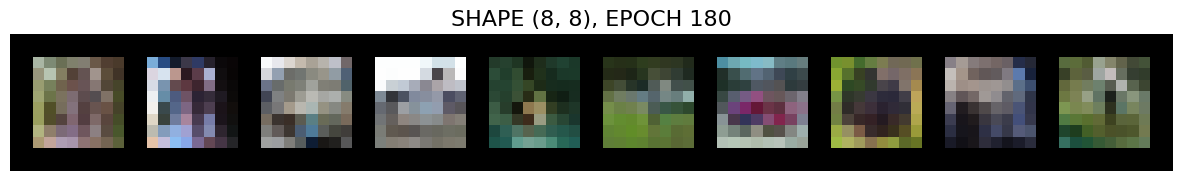

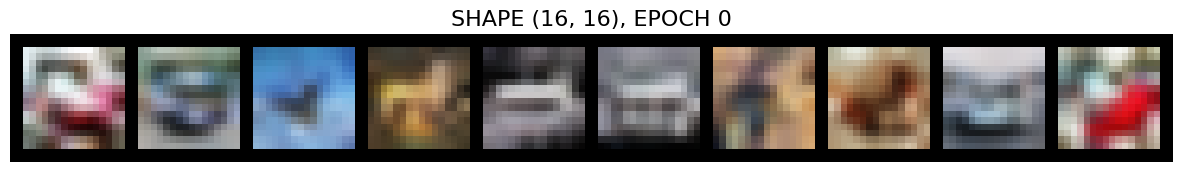

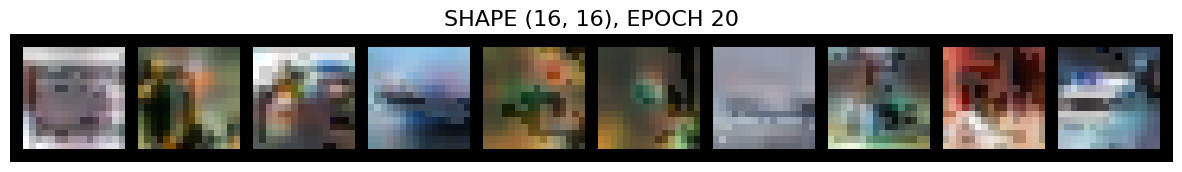

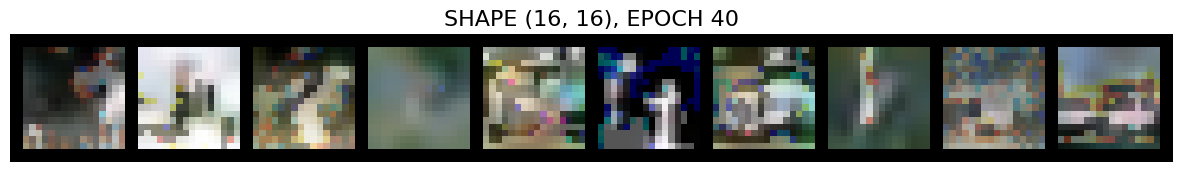

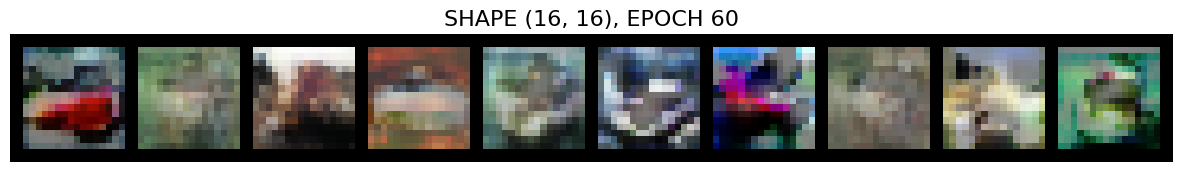

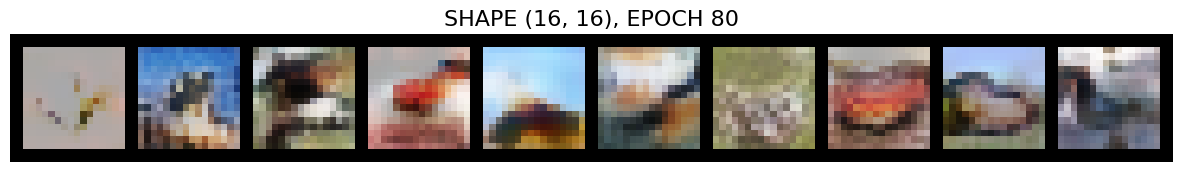

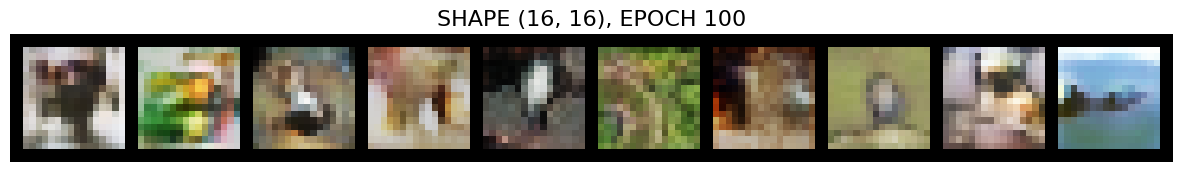

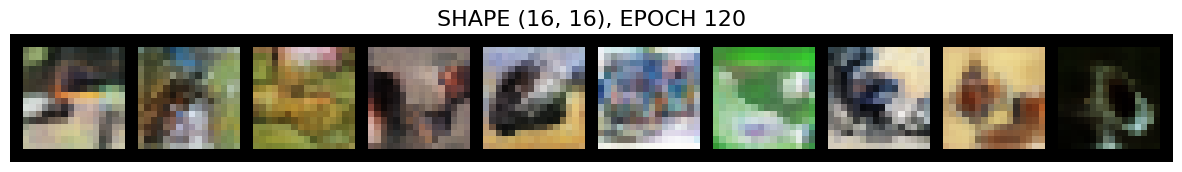

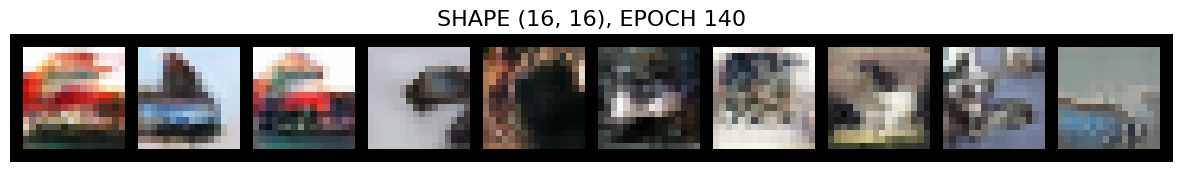

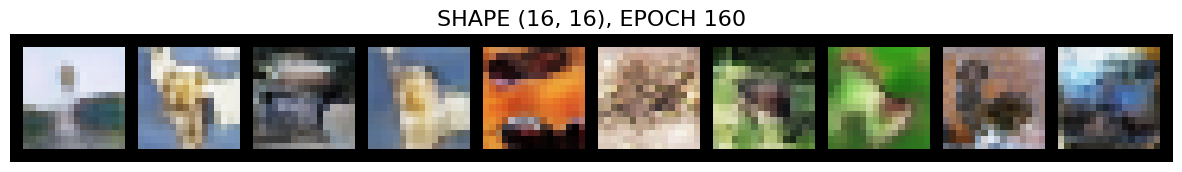

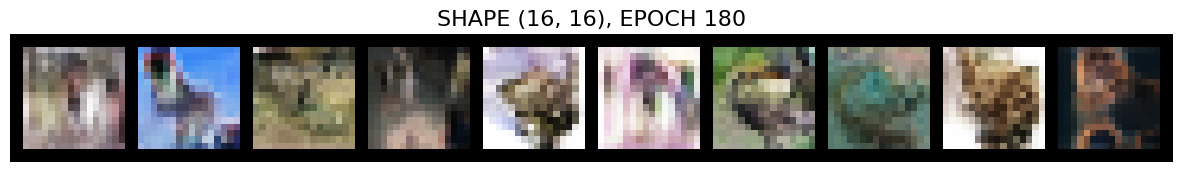

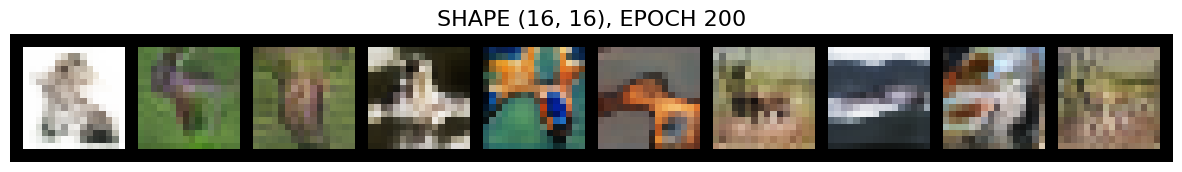

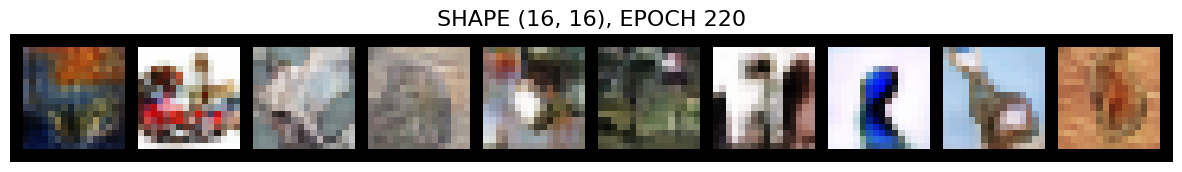

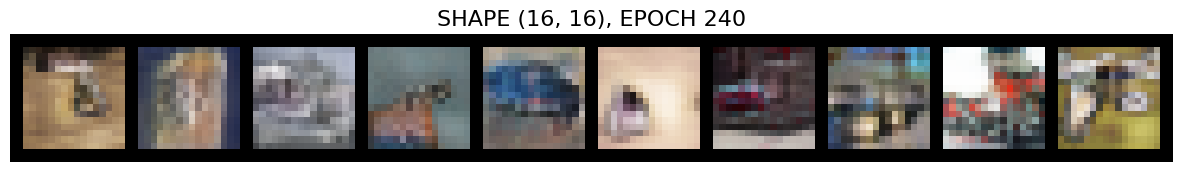

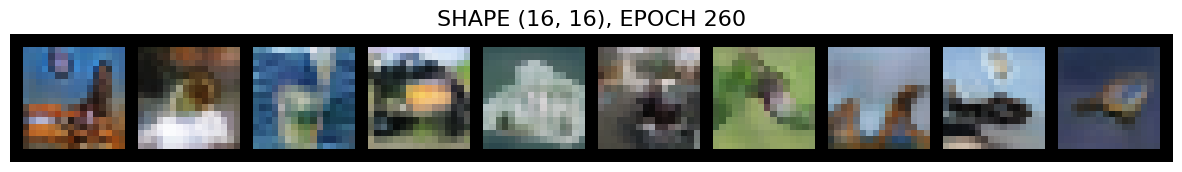

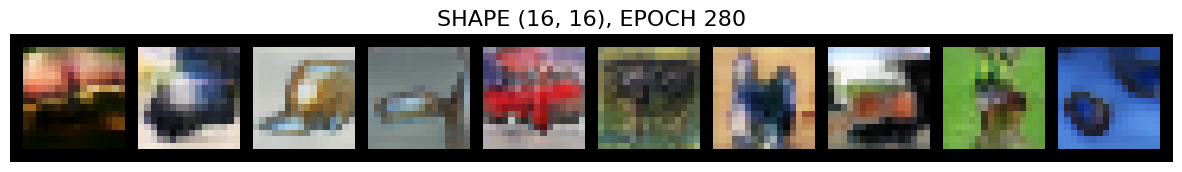

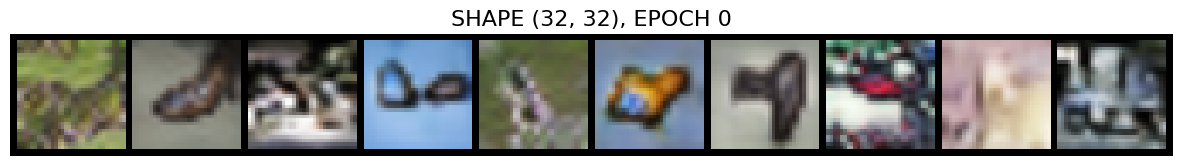

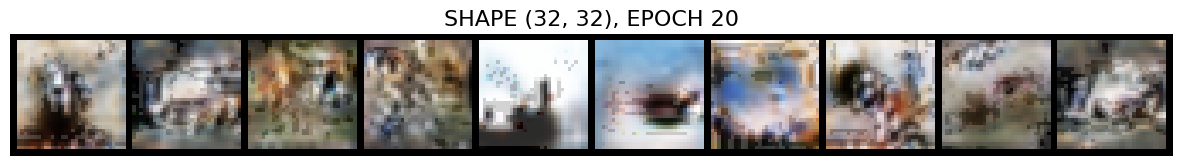

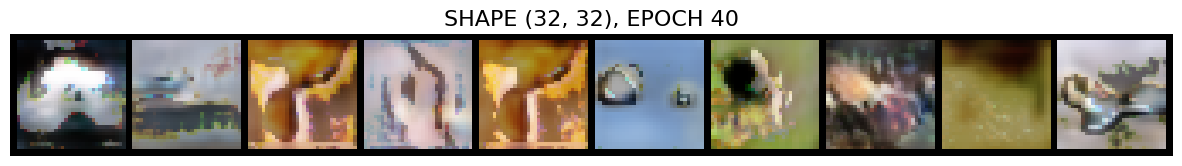

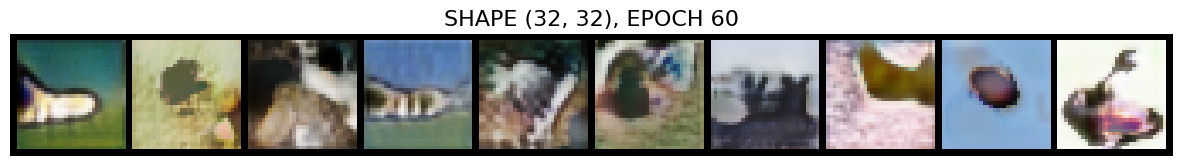

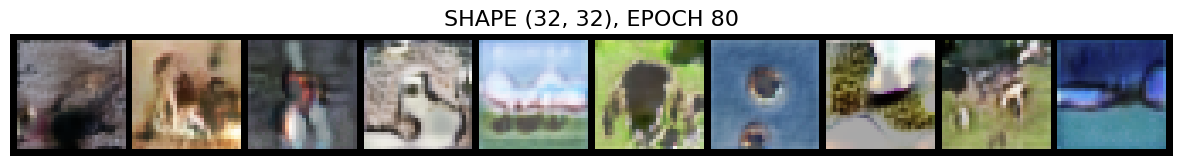

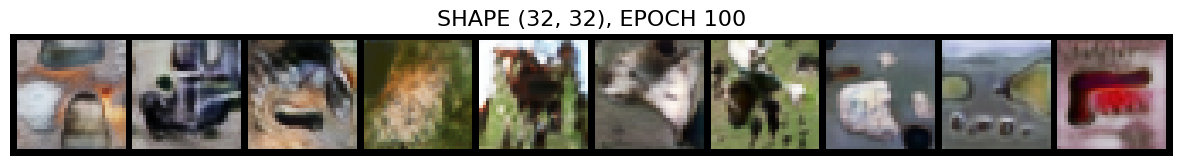

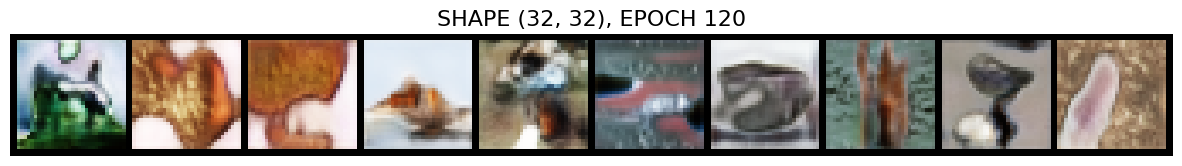

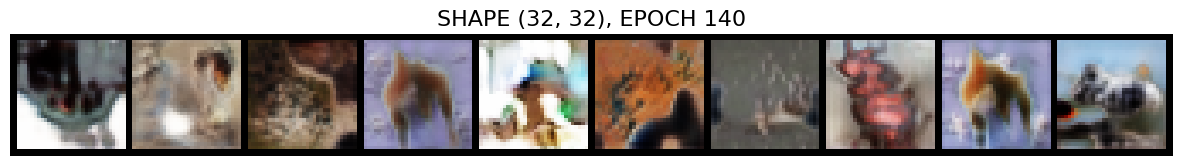

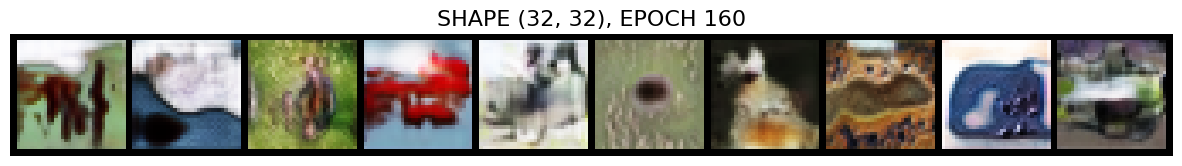

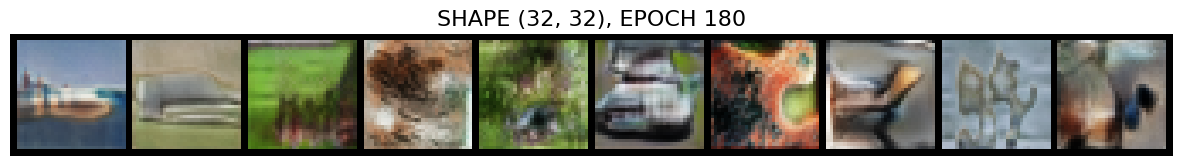

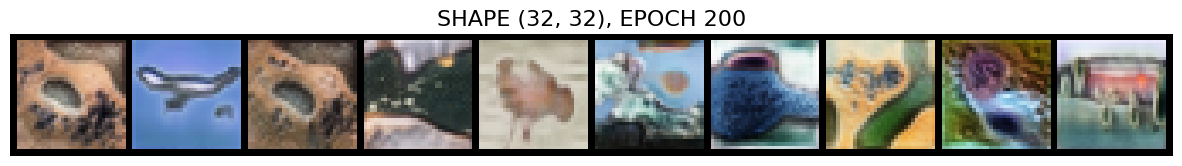

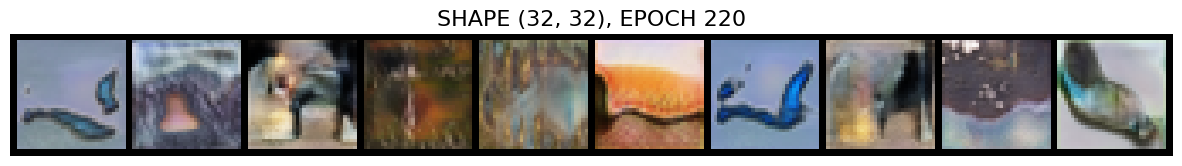

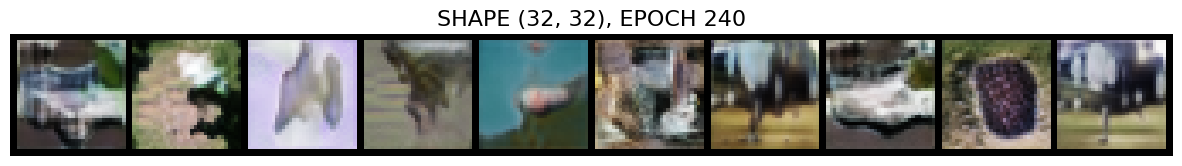

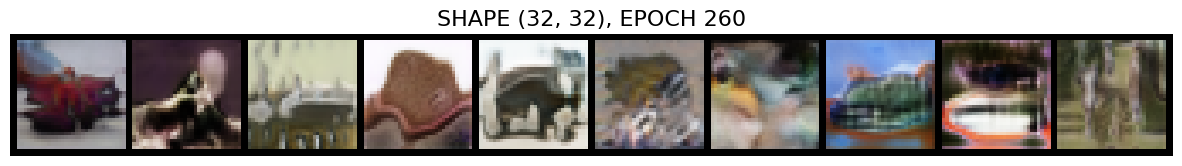

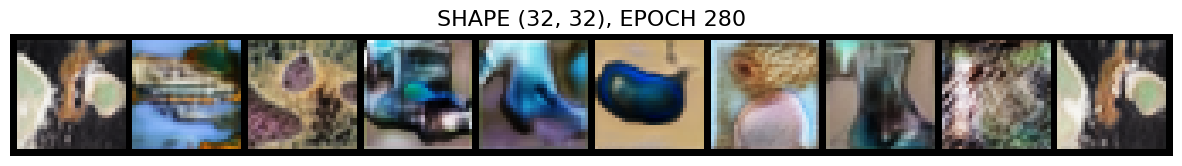

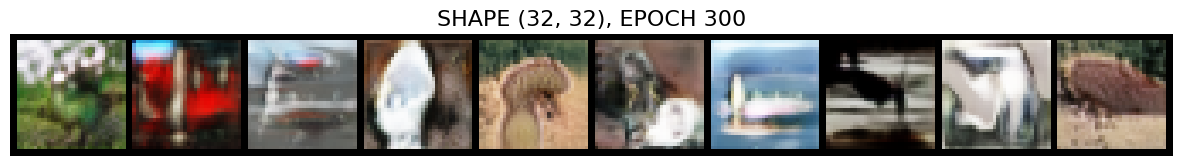

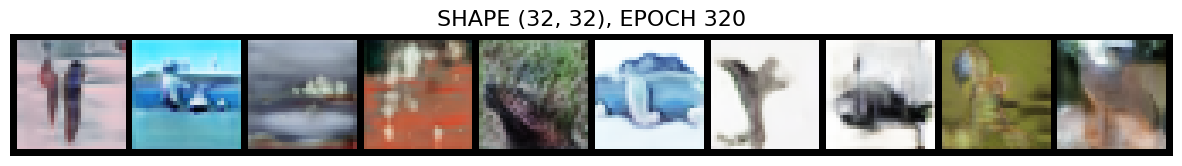

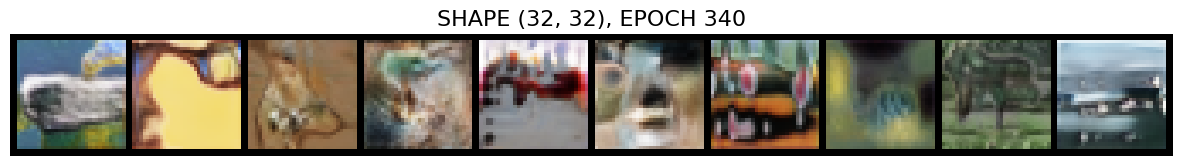

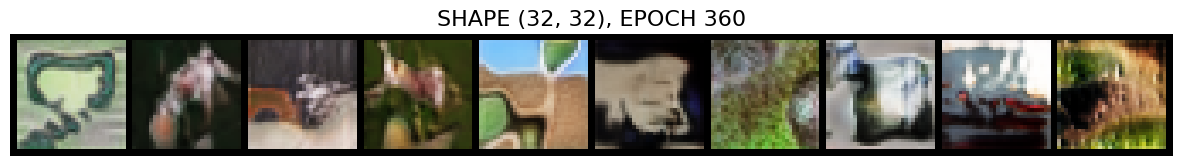

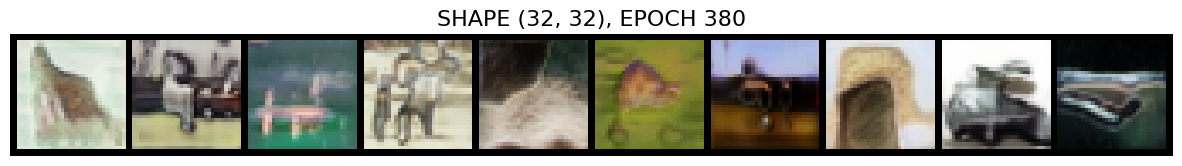

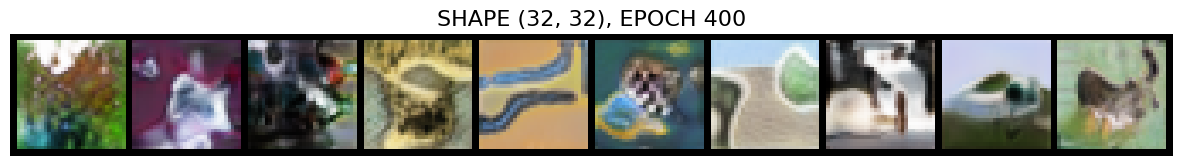

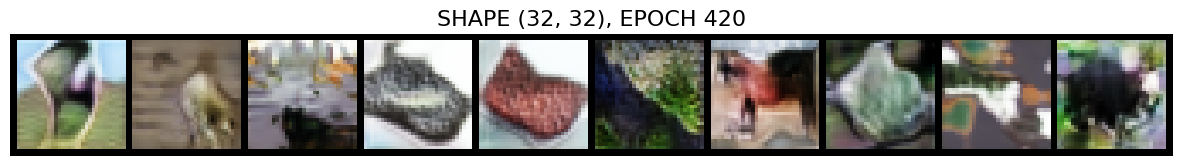

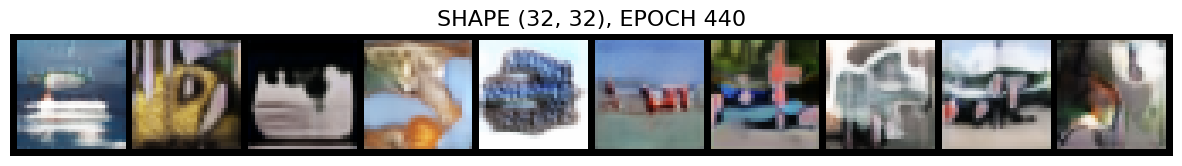

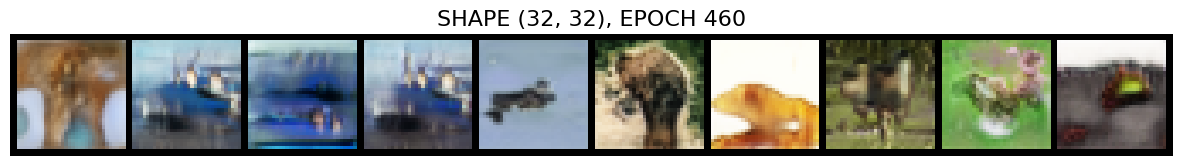

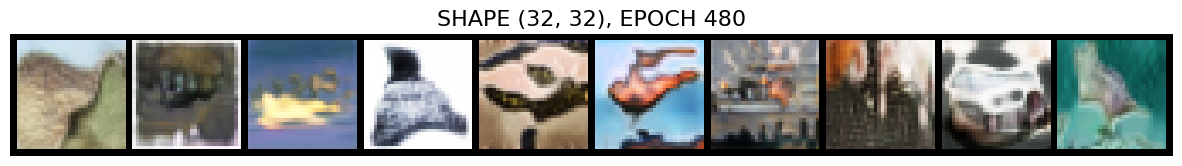

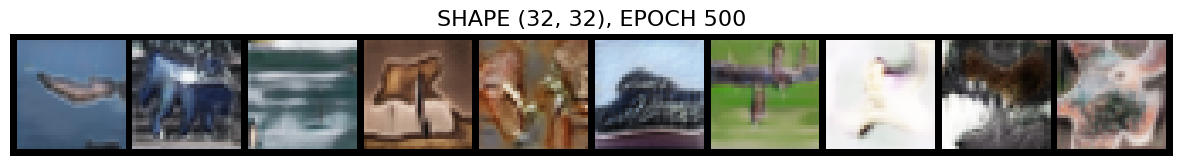

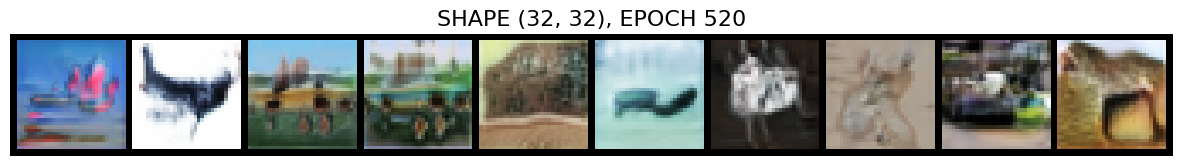

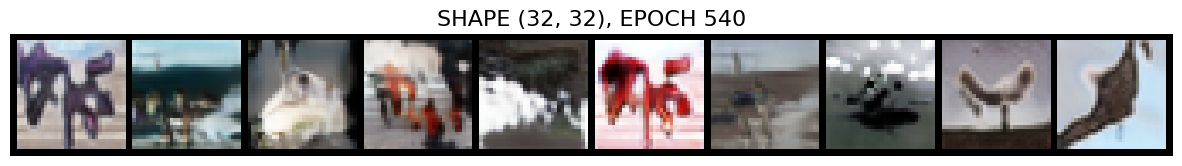

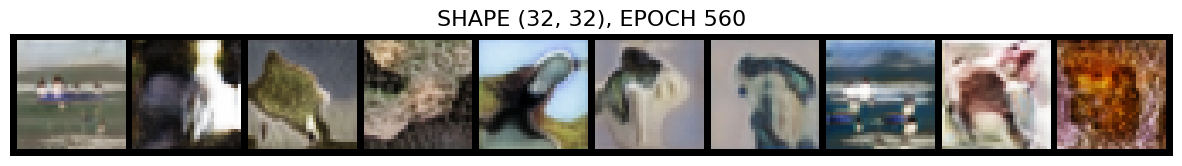

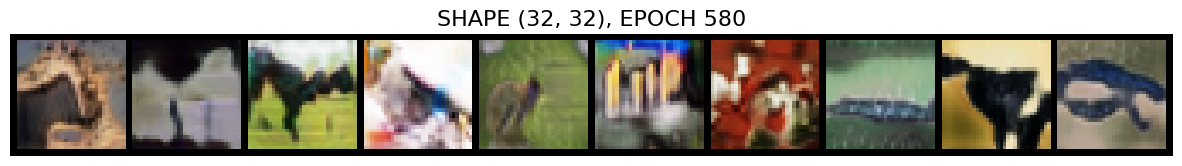

In [35]:
for res in IM.get_resolutions():
    for epoch in IM.get_epochs(res):
        batch = IM.get_images(res, epoch)[0]
        show_samples(batch, 'SHAPE ({0}, {0}), EPOCH {1}'.format(res, epoch), figsize=(15, 15), nrow=10)

### `w_mean` interpolation

Computation of `w_mean`

In [39]:
with torch.no_grad():
    noise = SG_generator._sample_prior(10000)
    w = SG_generator.map(noise)
    w_mean = w.mean(dim=0)

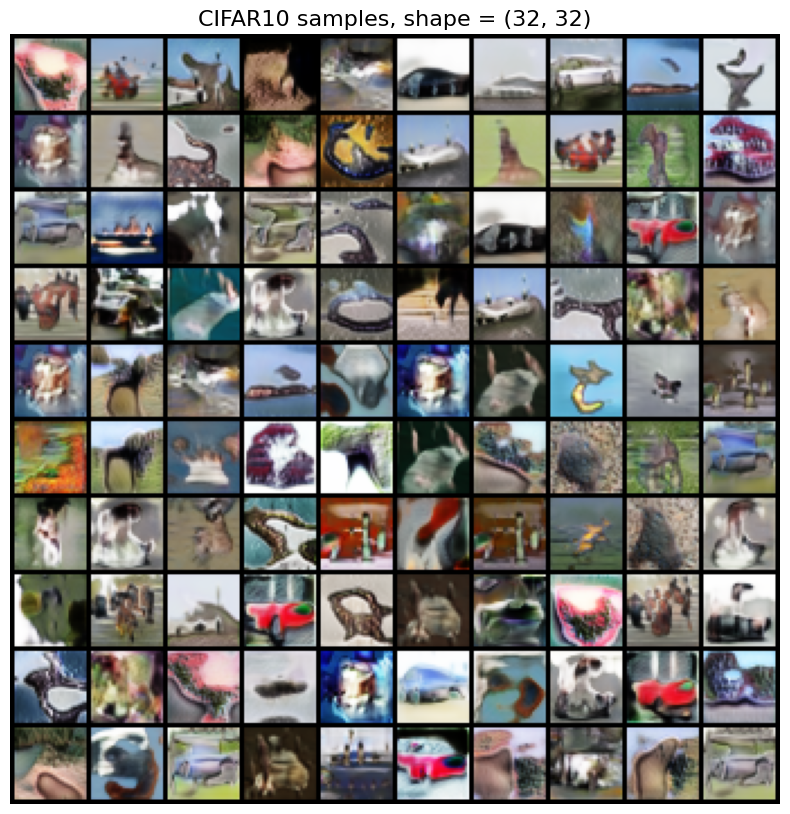

In [43]:
batch = rawim2im(SG_generator.sample(100, step=3, w_mean=w_mean, w_weight=1.0).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(10, 10), nrow=10)

## 11. Alternative versions of the model

### 11.1 GAN with $R_1$ (more training iterations)

In [44]:
SG_generator_alt = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=256,
    w_dim=64,
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32
).cuda()

In [45]:
checkpoint = torch.load('checkpoints_old/gan_loss_step_3_critic_lr_0.00100_gen_lr_0.00100_critic_steps_1_gp_1.0_v2_FINAL.pth', map_location=FULL_DEVICE)
SG_generator_alt.load_state_dict(checkpoint['generator'])

<All keys matched successfully>

Computation of `w_mean`

In [46]:
with torch.no_grad():
    noise = SG_generator_alt._sample_prior(10000)
    w = SG_generator_alt.map(noise)
    w_mean_alt = w.mean(dim=0)

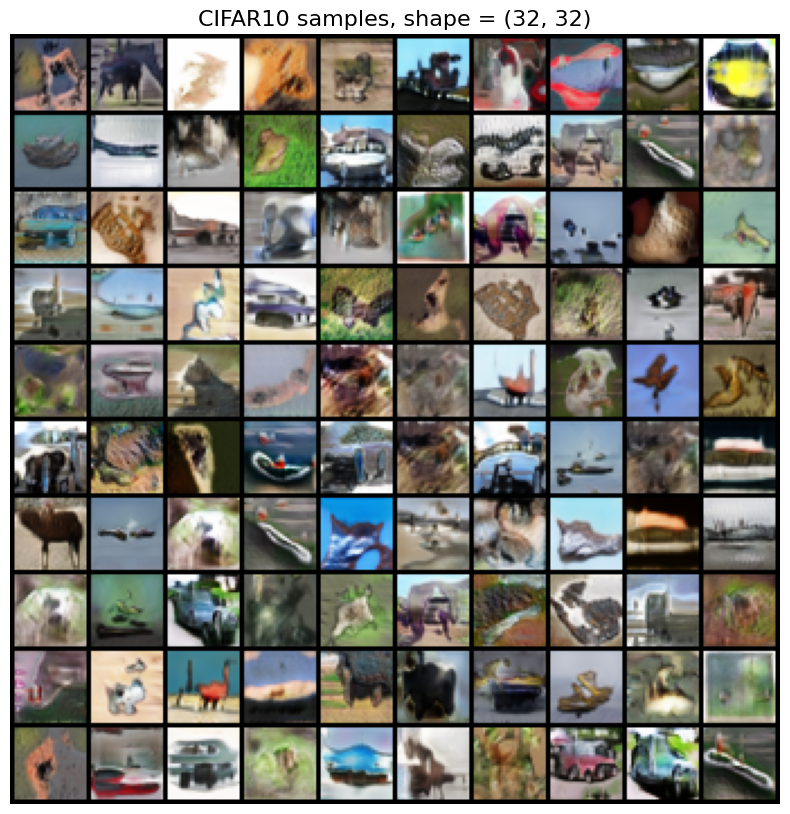

In [47]:
batch = rawim2im(SG_generator_alt.sample(100, step=3, w_mean=w_mean_alt, w_weight=1.0).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(10, 10), nrow=10)

### 11.2 WGAN-GP

In [48]:
SG_generator_wgan = MicroStyleGANGenerator(
    z_dim=z_dim, 
    map_hidden_dim=256,
    w_dim=64,
    in_chan=64,
    out_chan=out_chan, 
    kernel_size=3, 
    hidden_chan=32
).cuda()

In [49]:
checkpoint = torch.load(
    'checkpoints_old/wgan_tanh_loss_step_3_alpha_linear_6000_critic_lr_0.00070_gen_lr_0.00070_critic_steps_5_gp_1.0_FINAL.pth', map_location=FULL_DEVICE)
SG_generator_wgan.load_state_dict(checkpoint['generator'])

<All keys matched successfully>

Computation of `w_mean`

In [50]:
with torch.no_grad():
    noise = SG_generator_wgan._sample_prior(10000)
    w = SG_generator_wgan.map(noise)
    w_mean_wgangp = w.mean(dim=0)

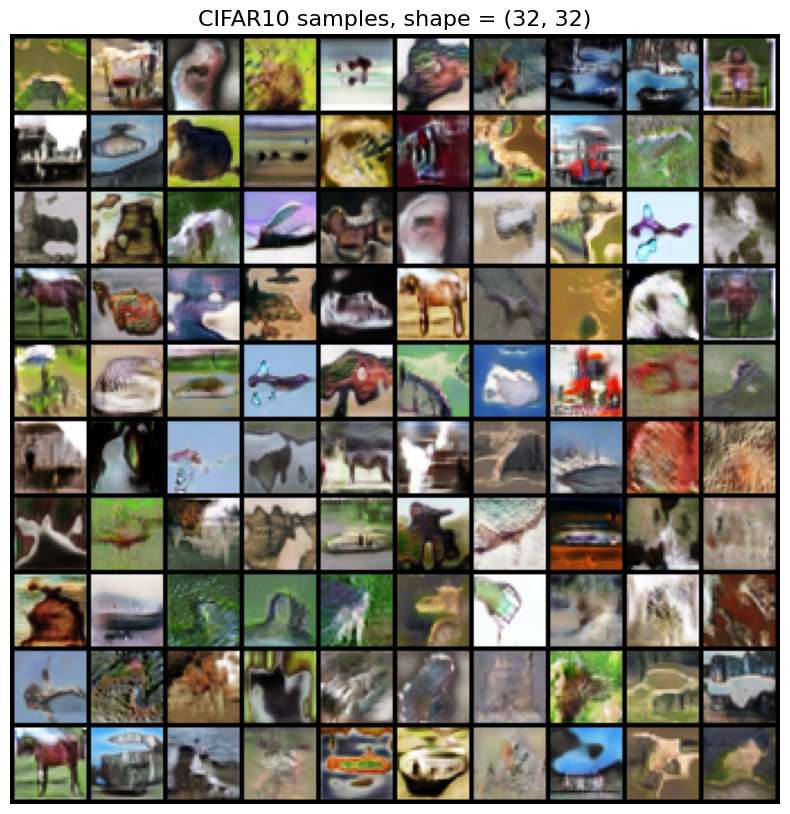

In [51]:
batch = rawim2im(SG_generator_wgan.sample(100, step=3, w_mean=w_mean_wgangp, w_weight=1.0).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(10, 10), nrow=10)

## 12. StyleGAN features

### 12.1 Style variation

In [53]:
def generate_styled(model, ws):
    assert len(ws) == 4
    with torch.no_grad():
        x = model.starting_constant
        for conv, w in zip(model.progression, ws):
            x = conv(x, w)
        return model.to_rgb[-1](x)

In [54]:
reset_seed()
with torch.no_grad():
    noise = SG_generator_alt._sample_prior(200)
    ws_basic = SG_generator_alt.map(noise).view(2, 100, -1)
    ws_map = {}
    for i in range(2):
        ws = ws_basic.clone()
        ws[i] = ws[i][0].unsqueeze(0).repeat_interleave(ws_basic.size(1), 0)
        ws_map[i] = [ws[0], ws[0], ws[1], ws[1]]

Fix `coarse`-grained, vary `fine`-grained

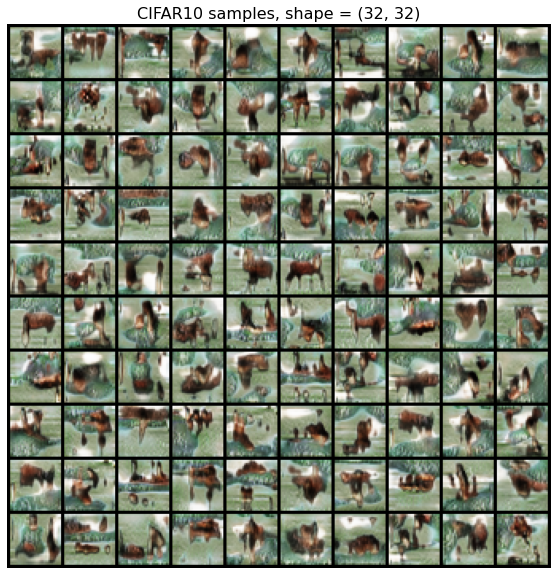

In [54]:
batch = rawim2im(generate_styled(SG_generator_alt, ws_map[1]).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(10, 10), nrow=10)

Vary `coarse`-grained, fix `fine`-grained

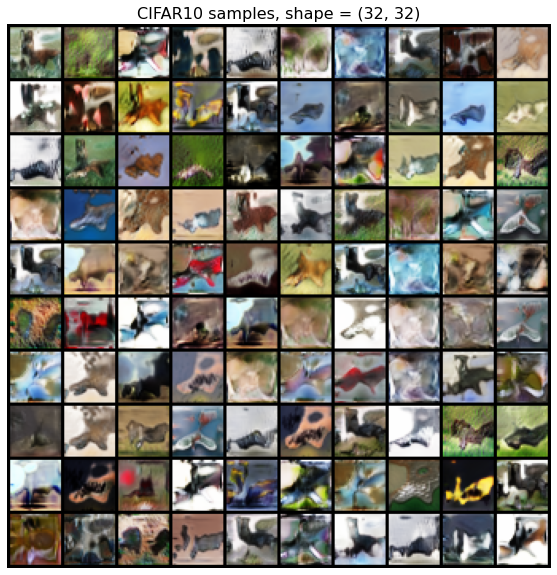

In [55]:
batch = rawim2im(generate_styled(SG_generator_alt, ws_map[0]).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(10, 10), nrow=10)

### 12.2 Playing with interpolation

In [56]:
def tsr_linspace(a, b, num):
    res = torch.zeros_like(a).unsqueeze(0).repeat_interleave(num + 1, 0)
    for i in range(num + 1):
        res[i] = a + i * (b - a)/num
    return res

reset_seed()
with torch.no_grad():
    noise = SG_generator_alt._sample_prior(4 * 20)
    ws_borders = SG_generator_alt.map(noise).view(20, 2, 2, -1)[19]
    ws_basic_linspace = tsr_linspace(ws_borders[0], ws_borders[1], 19).transpose(0, 1) # (2, 20, w_shape)

    ws_map = {}
    for i in range(2):
        ws = ws_basic_linspace.clone()
        ws[i] = ws[i][-1].unsqueeze(0).repeat_interleave(ws_basic_linspace.size(1), 0)
        ws_map[i] = [ws[0], ws[0], ws[1], ws[1]]

Fix `coarse`-grained, interpolate `fine`-grained

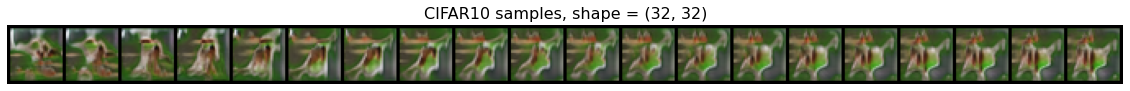

In [57]:
batch = rawim2im(generate_styled(SG_generator_alt, ws_map[1]).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(20, 20), nrow=20)

Interpolate `coarse`-grained, fix `fine`-grained

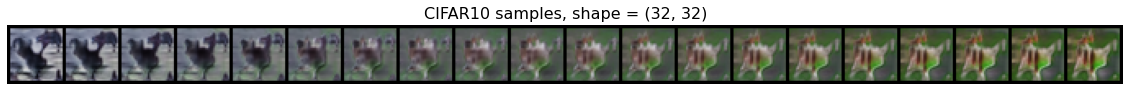

In [58]:
batch = rawim2im(generate_styled(SG_generator_alt, ws_map[0]).detach().cpu().numpy())
show_samples(batch, 'CIFAR10 samples, shape = ({0}, {0})'.format(32), figsize=(20, 20), nrow=20)